# Global spatial autocorrelation analysis for 2024 presidential election in Virginia

In [1]:
import matplotlib.pyplot as plt  # Graphics
from matplotlib import colors
import seaborn  # Graphics
import geopandas  # Spatial data manipulation
import pandas  # Tabular data manipulation
import rioxarray  # Surface data manipulation
import xarray  # Surface data manipulation
from pysal.explore import esda  # Exploratory Spatial analytics
from pysal.lib import weights  # Spatial weights
import contextily  # Background tiles

C:\Users\bsb5pw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\spaghetti\network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
# The vote results are stored in a csv file which we read into a dataframe:
va_vote_data_path = "./2024_VA_County_Level_Presidential_Results.csv"
va_vote_df = pandas.read_csv(va_vote_data_path)


In [3]:
# Convert the county_fips code to a string
va_vote_df['county_fips'] = va_vote_df['county_fips'].astype("string")

In [4]:
# calculate the percentage of votes 
va_vote_df['per_gop'] = va_vote_df['per_gop']*100
va_vote_df['per_dem'] = va_vote_df['per_dem']*100
va_vote_df['per_point_diff'] = va_vote_df['per_point_diff']*100

In [5]:
# Read in the shapefile for Virginia counties
VA_Counties_gdf = geopandas.read_file(
    "./VA_Counties.json"
)

In [6]:
# Select only the columns we need
VA_Counties_gdf= VA_Counties_gdf[["US_Counties_20m_GEOID","geometry"]]

In [7]:
# Merge the two dataframes on the county_fips column
db = VA_Counties_gdf.merge(va_vote_df, left_on="US_Counties_20m_GEOID", right_on="county_fips", how="left")


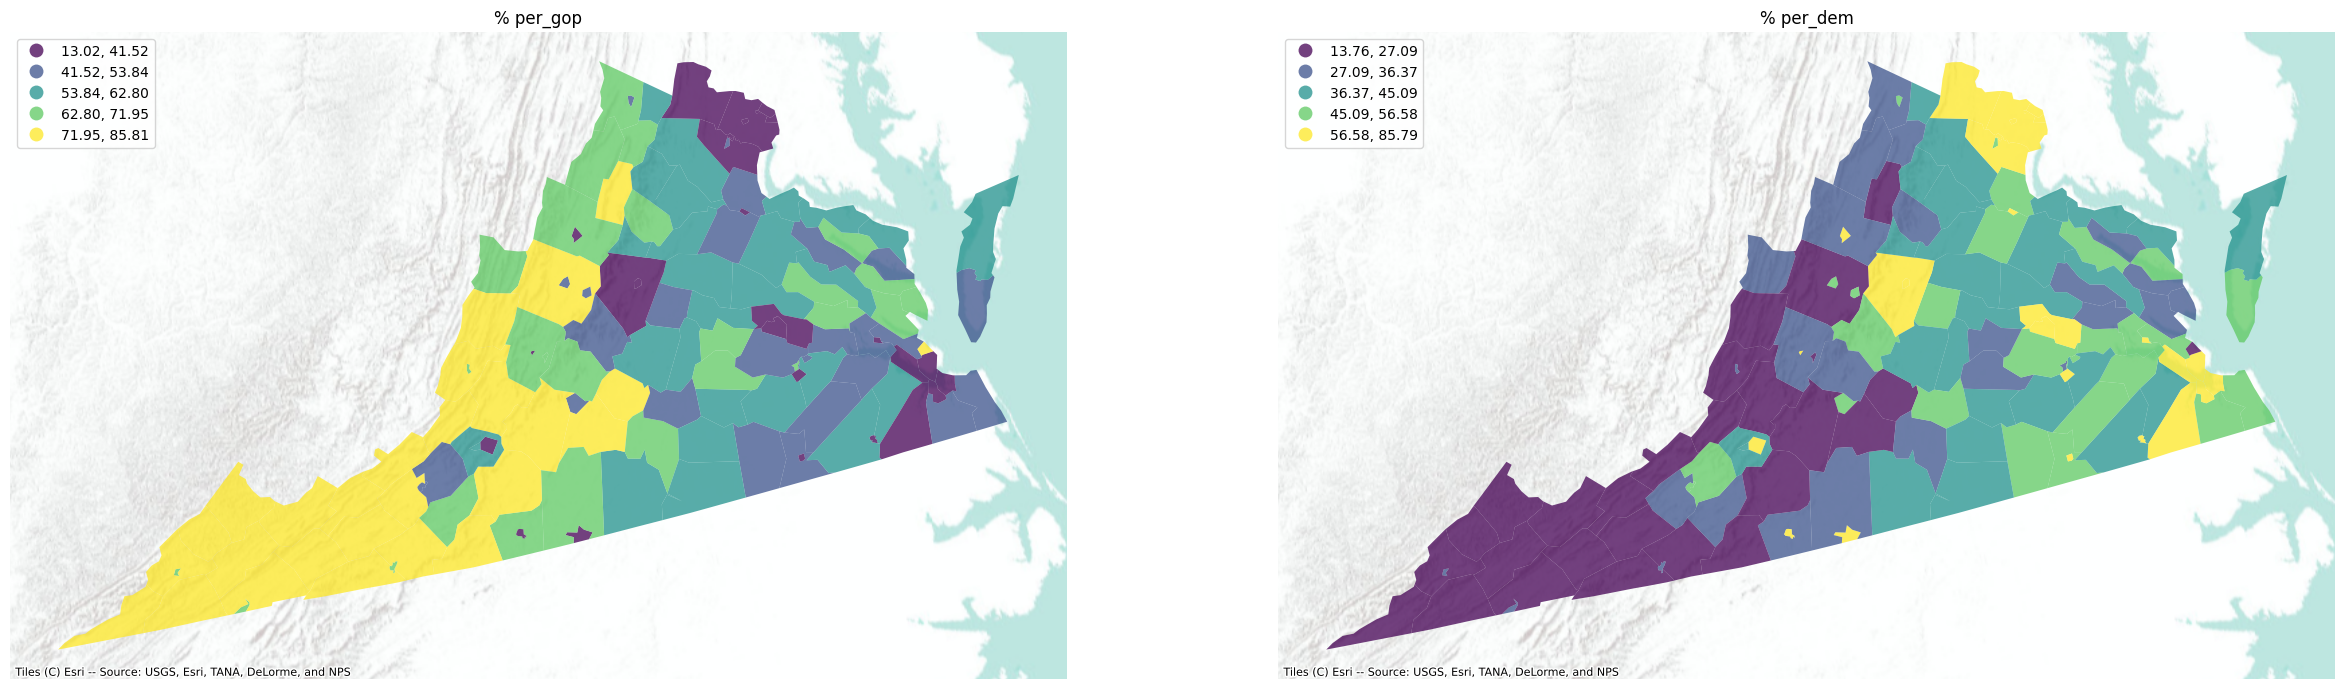

In [8]:
# Plotting the results of the per_gop and per_dem
f, axs = plt.subplots(1, 2,figsize=(30, 15))
ax1, ax2 = axs
db.plot(
    column="per_gop",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax1,
)
contextily.add_basemap(
    ax1,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)
ax1.set_title("% per_gop")
ax1.set_axis_off()

db.plot(
    column="per_dem",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax2,
)
contextily.add_basemap(
    ax2,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)
ax2.set_title("% per_dem")
ax2.set_axis_off()

In [11]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "R"

In [14]:
# Calculate the spatial lag
db["w_per_gop"] = weights.lag_spatial(w, db['per_gop'])
db["w_per_dem"] = weights.lag_spatial(w, db['per_dem'])

In [16]:
db["per_gop_std"] = db["per_gop"] - db["per_gop"].mean()
db["w_per_gop_std"] = weights.lag_spatial(w, db['per_gop_std'])

db["per_dem_std"] = db["per_dem"] - db["per_dem"].mean()
db["w_per_dem_std"] = weights.lag_spatial(w, db['per_dem_std'])

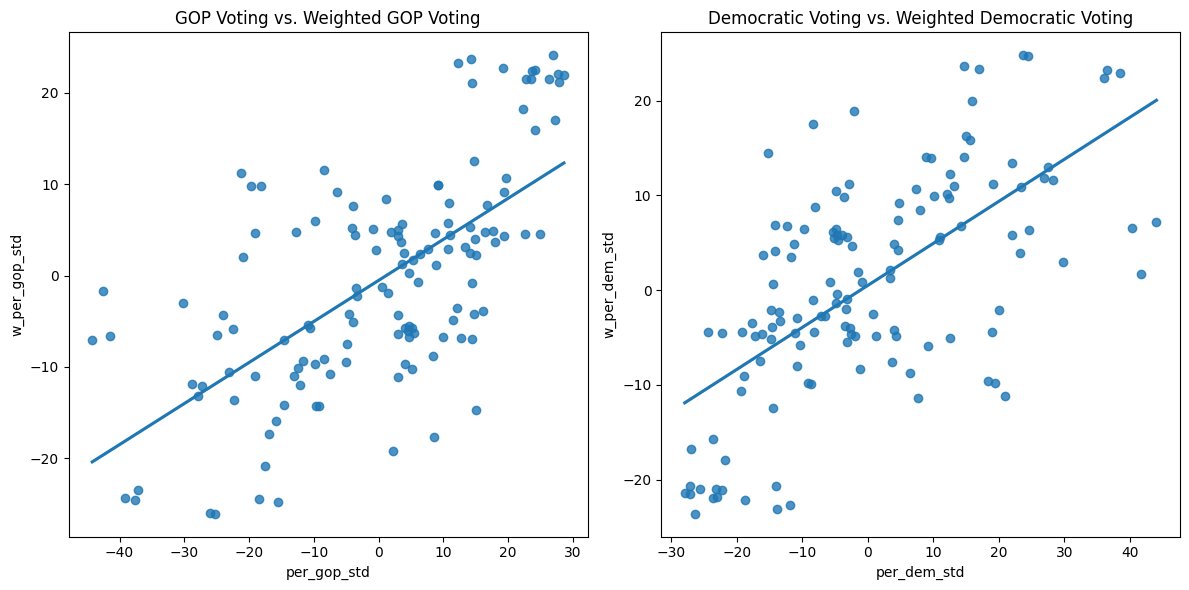

In [25]:


# Set up the figure with two subplots side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first regression line for GOP data
seaborn.regplot(
    x="per_gop_std", y="w_per_gop_std", data=db, ci=None, ax=ax1
)
ax1.set_title('GOP Voting vs. Weighted GOP Voting')

# Plot the second regression line for DEM data
seaborn.regplot(
    x="per_dem_std", y="w_per_dem_std", data=db, ci=None, ax=ax2
)
ax2.set_title('Democratic Voting vs. Weighted Democratic Voting')

# Display the plot
plt.tight_layout()
plt.show()


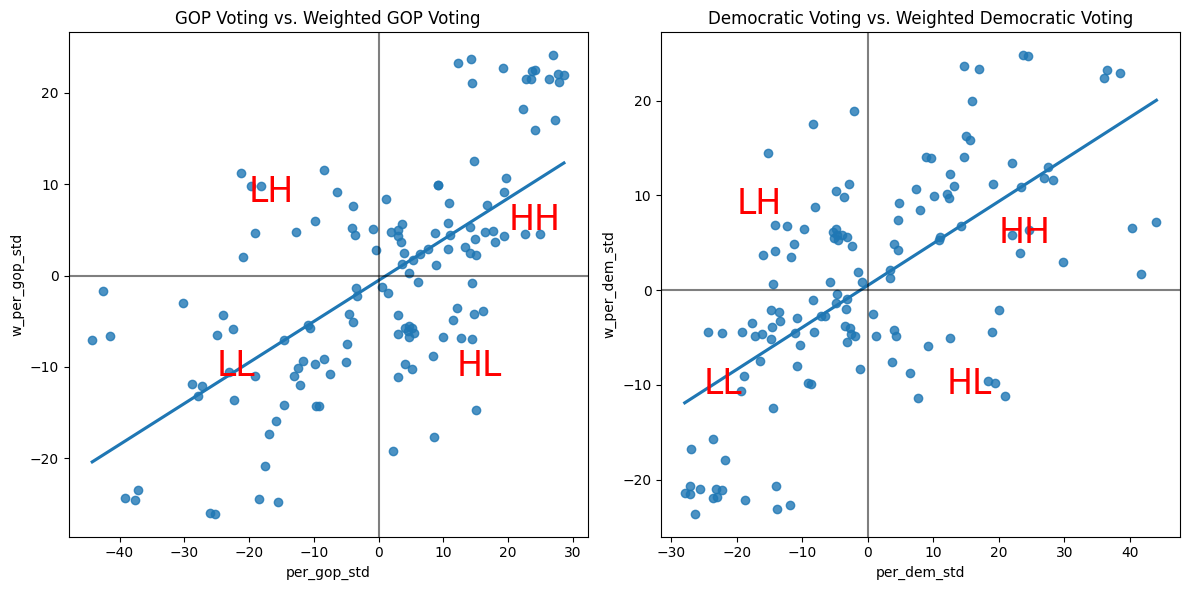

In [29]:

# Set up the figure with two subplots side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first regression line for GOP data on the first axis
seaborn.regplot(
    x="per_gop_std", y="w_per_gop_std", data=db, ci=None, ax=ax1
)
# Add vertical and horizontal lines
ax1.axvline(0, c="k", alpha=0.5)
ax1.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
ax1.text(20, 5, "HH", fontsize=25, c="r")
ax1.text(12, -11, "HL", fontsize=25, c="r")
ax1.text(-20, 8.0, "LH", fontsize=25, c="r")
ax1.text(-25, -11.0, "LL", fontsize=25, c="r")
ax1.set_title("GOP Voting vs. Weighted GOP Voting")

# Plot the second regression line for DEM data on the second axis
seaborn.regplot(
    x="per_dem_std", y="w_per_dem_std", data=db, ci=None, ax=ax2
)
# Add vertical and horizontal lines
ax2.axvline(0, c="k", alpha=0.5)
ax2.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
ax2.text(20, 5, "HH", fontsize=25, c="r")
ax2.text(12, -11, "HL", fontsize=25, c="r")
ax2.text(-20, 8.0, "LH", fontsize=25, c="r")
ax2.text(-25, -11.0, "LL", fontsize=25, c="r")
ax2.set_title("Democratic Voting vs. Weighted Democratic Voting")

# Display the plot
plt.tight_layout()
plt.show()
